# Summary

The dataset for this project was collected from [kaggle](https://www.kaggle.com/kevinarvai/clinvar-conflicting) and originates from [ClinVar](https://www.ncbi.nlm.nih.gov/clinvar/). ClinVar is a public resource containing annotations about human genetic variants. These variants are classified by clinical laboratories on a categorical spectrum ranging from benign, likely benign, uncertain significance, likely pathogenic, and pathogenic. Variants that have conflicting classifications (from laboratory to laboratory) can cause confusion when clinicians or researchers try to interpret whether the variant has an impact on the disease of a given patient.

The objective is to predict whether a ClinVar variant will have conflicting classifications. This is presented here as a binary classification problem, where each record in the dataset is a genetic variant.

Conflicting classifications are when two of any of the following three categories are present for one variant, two submissions of one category are not considered conflicting.

- Likely Benign or Benign
- VUS
- Likely Pathogenic or Pathogenic

Conflicting classification has been assigned to the CLASS column. It is a binary representation of whether or not a variant has conflicting classifications, where **0** represents **consistent classifications** and **1** represents **conflicting classifications**.

In this project, we will employ four different classifier models to find the best candidate algorithm that accurately predicts whether a ClinVar variant will have conflicting classifications.

# Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score

# Mute the sklearn and IPython warnings
import warnings
warnings.filterwarnings('ignore', module='sklearn')
warnings.filterwarnings('ignore', module='IPython')

In [2]:
data = pd.read_csv('./clinvar_conflicting.csv', sep=',')
data.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,1168180,G,C,0.0771,0.10020,0.1066,MedGen:CN169374,NaN,not_specified,...,tolerated,benign,NaN,NaN,NaN,NaN,NaN,1.053,-0.208682,2.0
1,1,1470752,G,A,0.0000,0.00000,0.0000,"MedGen:C1843891,OMIM:607454,Orphanet:ORPHA9877...",NaN,Spinocerebellar_ataxia_21|not_provided,...,deleterious_low_confidence,benign,NaN,NaN,NaN,NaN,NaN,31.000,6.517838,-3.0
2,1,1737942,A,G,0.0000,0.00001,0.0000,"Human_Phenotype_Ontology:HP:0000486,MedGen:C00...",NaN,Strabismus|Nystagmus|Hypothyroidism|Intellectu...,...,deleterious,probably_damaging,NaN,NaN,NaN,NaN,NaN,28.100,6.061752,-1.0
3,1,2160305,G,A,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002...",NaN,Shprintzen-Goldberg_syndrome|not_provided,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.500,3.114491,NaN
4,1,2160305,G,T,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002",NaN,Shprintzen-Goldberg_syndrome,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.700,4.766224,-3.0


In [3]:
data.shape

(65188, 46)

We have a lot more consistent than conflicting classifications.

In [4]:
data.CLASS.value_counts()

0    48754
1    16434
Name: CLASS, dtype: int64

In [5]:
pd.DataFrame([[i, len(data[i].unique())] for i in data.columns],
             columns=['Variable', 'Unique Values']).set_index('Variable')

,Unique Values
Variable,
CHROM,38
POS,63115
REF,866
ALT,458
AF_ESP,2842
AF_EXAC,6667
AF_TGP,2087
CLNDISDB,9234
CLNDISDBINCL,94


Dropping columns that have too many unique values and therefore they do not carry any information.

In [6]:
unique_col = pd.DataFrame([[i, len(data[i].unique())] for i in data.columns],
                          columns=['Variable', 'Unique Values']).set_index('Variable')

to_drop = list(unique_col[unique_col['Unique Values'] > 3000].index)
data.drop(to_drop, axis=1, inplace=True)

In [7]:
pd.DataFrame([[i, len(data[i].unique())] for i in data.columns],
             columns=['Variable', 'Unique Values']).set_index('Variable')

,Unique Values
Variable,
CHROM,38
REF,866
ALT,458
AF_ESP,2842
AF_TGP,2087
CLNDISDBINCL,94
CLNDNINCL,102
CLNSIGINCL,138
CLNVC,7


## Featureset Exploration

**CHROM**: Chromosome the variant is located on

**REF**: Reference Allele

**ALT**: Alternaete Allele

**AF_ESP**: Allele frequencies from GO-ESP

**AF_EXAC**: Allele frequencies from ExAC

**AF_TGP**: Allele frequencies from the 1000 genomes project

**CLNDISDB**: Tag-value pairs of disease database name and identifier, e.g. OMIM:NNNNNN

**CLNDISDBINCL**: For included Variant: Tag-value pairs of disease database name and identifier, e.g. OMIM:NN

**CLNDN**: ClinVar's preferred disease name for the concept specified by disease identifiers in CLNDISDB

More information on many of the features can be found at these two links:

https://useast.ensembl.org/info/docs/tools/vep/vep_formats.html#output

https://useast.ensembl.org/info/genome/variation/prediction/predicted_data.html#consequences

In [8]:
num_missing = data.isnull().sum()
percentage_missing = data.isnull().sum().apply(lambda x: x/data.shape[0]*100)

In [9]:
missing_data = pd.DataFrame({'Number of Missing':  num_missing,
                             'Percentage of Missing': percentage_missing})

missing_data['Percentage of Missing'].sort_values(ascending = False)

MOTIF_SCORE_CHANGE    99.996932
HIGH_INF_POS          99.996932
MOTIF_POS             99.996932
MOTIF_NAME            99.996932
DISTANCE              99.834325
SSR                   99.800577
CLNDISDBINCL          99.743818
CLNSIGINCL            99.743818
CLNDNINCL             99.743818
INTRON                86.495981
PolyPhen              61.962324
SIFT                  61.900963
BLOSUM62              60.739707
BAM_EDIT              50.958765
Amino_acids           15.346383
Codons                15.346383
LoFtool                6.462846
MC                     1.297785
SYMBOL                 0.024544
BIOTYPE                0.024544
Feature_type           0.021476
Feature                0.021476
STRAND                 0.021476
Consequence            0.000000
Allele                 0.000000
CLASS                  0.000000
IMPACT                 0.000000
ORIGIN                 0.000000
CLNVC                  0.000000
AF_TGP                 0.000000
AF_ESP                 0.000000
ALT     

Drop the columns where more than 20% of the data is missing.

In [10]:
drop_list = list(missing_data[missing_data['Percentage of Missing'] >= 20].index)
data.drop(drop_list,axis = 1, inplace=True)

In [11]:
data.isnull().sum()

CHROM               0
REF                 0
ALT                 0
AF_ESP              0
AF_TGP              0
CLNVC               0
MC                846
ORIGIN              0
CLASS               0
Allele              0
Consequence         0
IMPACT              0
SYMBOL             16
Feature_type       14
Feature            14
BIOTYPE            16
Amino_acids     10004
Codons          10004
STRAND             14
LoFtool          4213
dtype: int64

<AxesSubplot:>

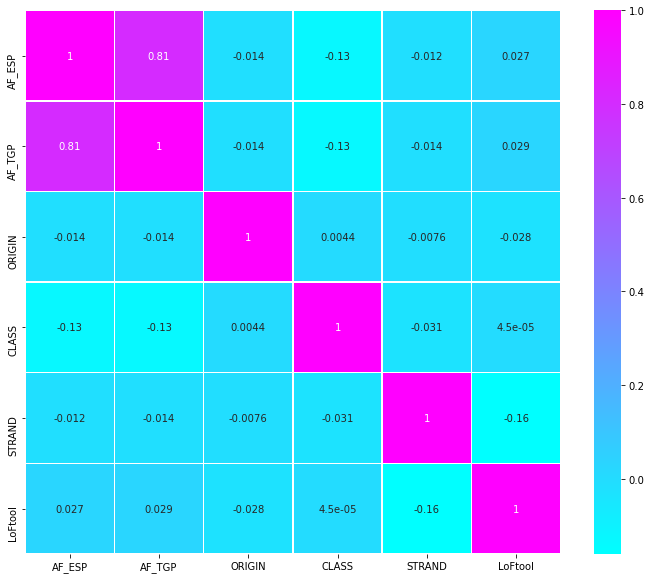

In [12]:
plt.figure(figsize = (12, 10))
sns.heatmap(data.corr(), annot = True, linewidths=.5, cmap = plt.cm.cool)

The correlation of **AF_ESP** with **AF_TGP** is above 0.8 hence dropping the **AF_TGP** column.

In [13]:
data.drop(['AF_TGP'],axis = 1, inplace=True)

In [14]:
# check the types
df = pd.DataFrame(data.isnull().sum().astype(int), columns=['Null'])
null_list = list(df[df['Null'] != 0].index)
data[null_list].dtypes

MC               object
SYMBOL           object
Feature_type     object
Feature          object
BIOTYPE          object
Amino_acids      object
Codons           object
STRAND          float64
LoFtool         float64
dtype: object

In [15]:
data[null_list].sample(5)

,MC,SYMBOL,Feature_type,Feature,BIOTYPE,Amino_acids,Codons,STRAND,LoFtool
16552,SO:0001819|synonymous_variant,WNK1,Transcript,XM_005253733.1,protein_coding,Y,taC/taT,1.0,0.54000
22550,SO:0001583|missense_variant,ESRRB,Transcript,XM_005267403.1,protein_coding,P/L,cCg/cTg,1.0,0.19300
46034,SO:0001819|synonymous_variant,JPH2,Transcript,NM_020433.4,protein_coding,K,aaG/aaA,-1.0,NaN
42307,SO:0001583|missense_variant,TTN,Transcript,NM_001267550.1,protein_coding,I/V,Atc/Gtc,-1.0,0.97100
60830,SO:0001583|missense_variant,PLEC,Transcript,XM_005250976.1,protein_coding,A/T,Gcc/Acc,-1.0,0.00999


# Feature Transformation

- Replace nan in **MC**, **SYMBOL**, **Feature_type**, **Feature**, **BIOTYPE**, **Amino_acids**, **Codons**, **STRAND** with the most frequent value
- Replace nan in **LoFtool** with the mean 

In [16]:
for x in ["MC", "SYMBOL", "Feature_type", "Feature", 
          "BIOTYPE", "STRAND", "Amino_acids", "Codons" ]:
    data[x].fillna(data[x].mode()[0], inplace=True)

data['LoFtool'].fillna(data['LoFtool'].mean(), inplace=True)

data.isnull().sum()

CHROM           0
REF             0
ALT             0
AF_ESP          0
CLNVC           0
MC              0
ORIGIN          0
CLASS           0
Allele          0
Consequence     0
IMPACT          0
SYMBOL          0
Feature_type    0
Feature         0
BIOTYPE         0
Amino_acids     0
Codons          0
STRAND          0
LoFtool         0
dtype: int64

Now identify which variables are binary, categorical and ordinal by looking at the number of unique values each variable takes, then create list variables for categorical, numeric, binary, and ordinal variables.

In [17]:
dg = pd.DataFrame([[str(i),data[i].dtypes == 'object'] for i in data.columns],
                  columns=['Variable','Object Type']).set_index('Variable')
object_columns_names = list(dg[dg['Object Type'] == True].index)

In [18]:
#display the number of unique values for columns type object
df = data[object_columns_names]
df_uniques = pd.DataFrame([[i, len(df[i].unique())] for i in df.columns],
                          columns=['Variable', 'Unique Values']).set_index('Variable')

In [19]:
df_uniques

,Unique Values
Variable,
CHROM,38
REF,866
ALT,458
CLNVC,7
MC,90
Allele,374
Consequence,48
IMPACT,4
SYMBOL,2328


In [20]:
binary_variables = list(df_uniques[df_uniques['Unique Values'] == 2].index)
binary_variables

['Feature_type', 'BIOTYPE']

In [21]:
categorical_variables = list(df_uniques[(df_uniques['Unique Values'] > 2)].index)
categorical_variables

['CHROM',
 'REF',
 'ALT',
 'CLNVC',
 'MC',
 'Allele',
 'Consequence',
 'IMPACT',
 'SYMBOL',
 'Feature',
 'Amino_acids',
 'Codons']

In [22]:
for col in categorical_variables:
    data[col] = data[col].apply(lambda x: str(x))

data[categorical_variables].dtypes

CHROM          object
REF            object
ALT            object
CLNVC          object
MC             object
Allele         object
Consequence    object
IMPACT         object
SYMBOL         object
Feature        object
Amino_acids    object
Codons         object
dtype: object

In [23]:
numeric_variables = list(set(data.columns) - set(categorical_variables) - set(binary_variables))
data[numeric_variables].dtypes

CLASS        int64
LoFtool    float64
STRAND     float64
ORIGIN       int64
AF_ESP     float64
dtype: object

In [24]:
lb, le = LabelBinarizer(), LabelEncoder()

#encoding ordinary variables
for col in categorical_variables:
    data[col] = le.fit_transform(data[col])

# binary encoding binary variables
for col in binary_variables:
    data[col] = lb.fit_transform(data[col])

In [25]:
data.sample(3)

,CHROM,REF,ALT,AF_ESP,CLNVC,MC,ORIGIN,CLASS,Allele,Consequence,IMPACT,SYMBOL,Feature_type,Feature,BIOTYPE,Amino_acids,Codons,STRAND,LoFtool
29581,8,644,213,0.0,6,10,1,0,168,24,0,1404,1,2104,1,78,1163,1.0,0.116000
57695,19,644,106,0.0,6,81,1,0,88,31,1,1430,1,1967,1,78,1163,1.0,0.345058
21641,5,437,0,0.0,6,89,1,1,1,46,1,1340,1,2251,1,201,1643,-1.0,0.068400


<AxesSubplot:>

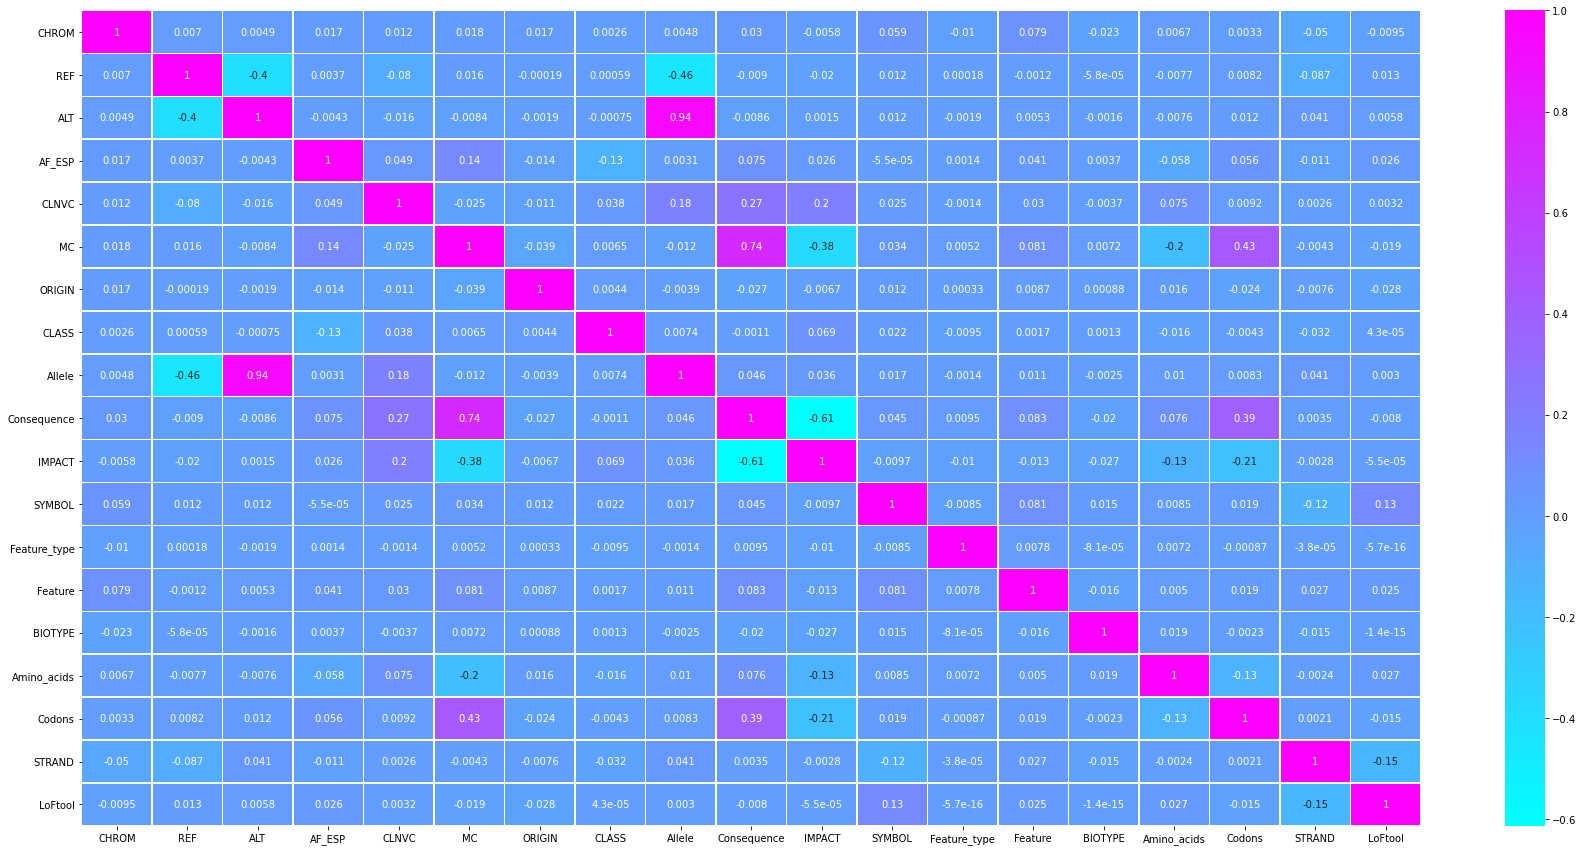

In [26]:
plt.figure(figsize = (30, 15))
sns.heatmap(data.corr(), annot = True, linewidths=.5, cmap = plt.cm.cool)

The correlation of **ALT** with **Allele** and **MC** with **Consequence** are both above 0.8 hence dropping the **ALT** and **MC** columns.

In [27]:
data.drop(["ALT", "MC"],axis = 1, inplace=True)
categorical_variables.remove('ALT')
categorical_variables.remove("MC")

# Apply Feature Scaling

In [28]:
mm = MinMaxScaler()
for column in [categorical_variables + numeric_variables]:
    data[column] = mm.fit_transform(data[column])

In [29]:
# Save a copy of the processed data for later use
outputfile = 'clinvar_conflicting_processed.csv'
data.to_csv(outputfile, index=False)

# Split the data

Split the data into train and test data sets using **StratifiedShuffleSplit** to maintain the same ratio of predictor classes.

In [30]:
data = pd.read_csv('./clinvar_conflicting_processed.csv', sep=',')

In [31]:
feature_cols = list(data.columns)
feature_cols.remove('CLASS')

In [32]:
# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.CLASS))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'CLASS']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'CLASS']
len(X_test), len(X_train)

(19557, 45631)

# Train models

- Standard logistic regression, K-nearest neighbors algorithm, Decision Tree,mRandom Forest
- Plot the results using heatmaps
- Compare scores: precision, recall, accuracy, F1 score, auc

## Logistic Regression

In [33]:
# create dataframe for metrics
metrics = pd.DataFrame()

# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

precision_lr, recall_lr = (round(float(x),2) for x in list(score(y_test,
                                                                    y_pred_lr,
                                                                    average='weighted'))[:-2])
# adding lr stats to metrics DataFrame
lr_stats = pd.Series({'precision':precision_lr,
                      'recall':recall_lr,
                      'accuracy':round(accuracy_score(y_test, y_pred_lr), 2),
                      'f1score':round(f1_score(y_test, y_pred_lr), 2),
                      'auc': round(roc_auc_score(y_test, y_pred_lr),2)},
                     name='Logistic Regression')
# Report outcomes
pd.DataFrame(classification_report(y_test, y_pred_lr, output_dict=True)).iloc[:3,:2]

,0.0,1.0
precision,0.747773,0.130435
recall,0.998633,0.000609
f1-score,0.855186,0.001211


## K-nearest Neighbors

In [34]:
# Estimate KNN model and report outcomes
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn = knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

precision_knn, recall_knn = (round(float(x),2) for x in list(score(y_test,
                                                                      y_pred_knn,
                                                                      average='weighted'))[:-2])
# adding KNN stats to metrics DataFrame
knn_stats = pd.Series({'precision':precision_knn,
                      'recall':recall_knn,
                      'accuracy':round(accuracy_score(y_test, y_pred_knn), 2),
                      'f1score':round(f1_score(y_test, y_pred_knn), 2),
                      'auc': round(roc_auc_score(y_test, y_pred_knn),2)}, name='KNN')
# Report outcomes
pd.DataFrame(classification_report(y_test, y_pred_knn, output_dict=True)).iloc[:3,:2]

,0.0,1.0
precision,0.773786,0.349403
recall,0.817324,0.291075
f1-score,0.794960,0.317583


## Decision Tree

In [35]:
dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train)
dt.tree_.node_count, dt.tree_.max_depth

(21179, 44)

In [36]:
y_train_pred = dt.predict(X_train)
y_pred_dt = dt.predict(X_test)

precision_dt, recall_dt = (round(float(x),2) for x in list(score(y_test,
                                                                y_pred_dt,
                                                                average='weighted'))[:-2])
# adding dt stats to metrics DataFrame
dt_stats = pd.Series({'precision':precision_dt,
                      'recall':recall_dt,
                      'accuracy':round(accuracy_score(y_test, y_pred_dt), 2),
                      'f1score':round(f1_score(y_test, y_pred_dt), 2),
                      'auc': round(roc_auc_score(y_test, y_pred_dt),2)}, name='Decision Tree')
# Report outcomes
pd.DataFrame(classification_report(y_test, y_pred_dt, output_dict=True)).iloc[:3,:2]

,0.0,1.0
precision,0.788235,0.381372
recall,0.803377,0.359635
f1-score,0.795734,0.370185


## Random forest

In [37]:
# Initialize the random forest estimator
RF = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)

# initialise list for out of bag error
oob_list = list()

# Iterate through all of the possibilities for number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    # Use this to set the number of trees
    RF.set_params(n_estimators=n_trees)
    
    # Fit the model
    RF.fit(X_train, y_train)
    
    # Get the out of bag error and store it
    oob_error = 1 - RF.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

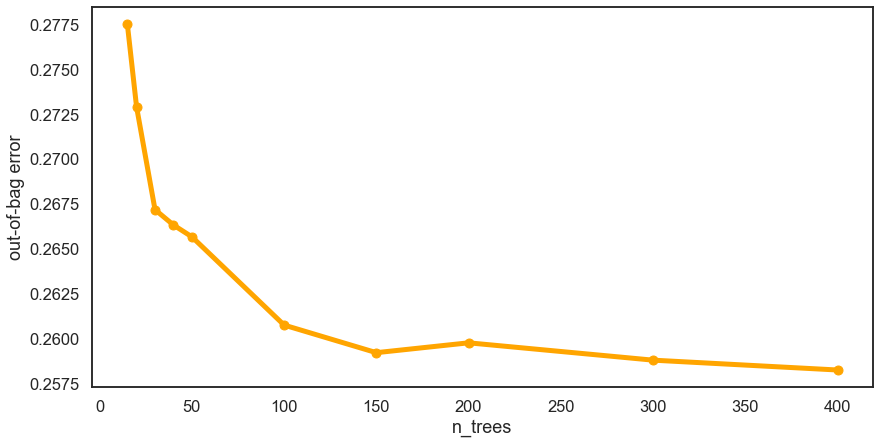

In [38]:
sns.set_context('talk')
sns.set_style('white')

ax = rf_oob_df.plot(legend=False, marker='o', color="orange", figsize=(14, 7), linewidth=5)
ax.set(ylabel='out-of-bag error');

The error looks like it has stabilized around 100-150 trees.

In [39]:
rf = RF.set_params(n_estimators=100)

y_pred_rf = rf.predict(X_test)
precision_rf, recall_rf = (round(float(x),2) for x in list(score(y_test,
                                                                    y_pred_rf,
                                                                    average='weighted'))[:-2])
rf_stats = pd.Series({'precision':precision_rf,
                      'recall':recall_rf,
                      'accuracy':round(accuracy_score(y_test, y_pred_rf), 2),
                      'f1score':round(f1_score(y_test, y_pred_rf), 2),
                      'auc': round(roc_auc_score(y_test, y_pred_rf),2)}, name='Random Forest')
# Report outcomes
pd.DataFrame(classification_report(y_test, y_pred_rf, output_dict=True)).iloc[:3,:2]

,0.0,1.0
precision,0.785655,0.484793
recall,0.903876,0.268357
f1-score,0.840629,0.345476


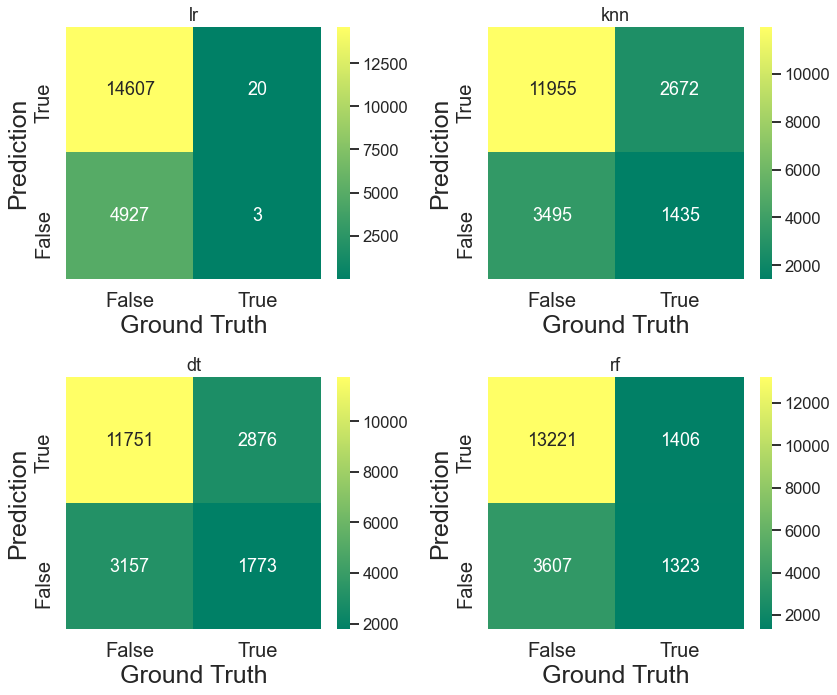

In [40]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)


models = coeff_labels = ['lr', 'knn', 'dt', 'rf']
cm = [confusion_matrix(y_test, y_pred_lr),
      confusion_matrix(y_test, y_pred_knn),
      confusion_matrix(y_test, y_pred_dt),
      confusion_matrix(y_test, y_pred_rf)]
labels = ['False', 'True']

for ax,model, idx in zip(axList, models, range(0,4)):
    sns.heatmap(cm[idx], ax=ax, annot=True, fmt='d', cmap='summer');
    ax.set(title=model);
    ax.set_xticklabels(labels, fontsize=20);
    ax.set_yticklabels(labels[::-1], fontsize=20);
    ax.set_ylabel('Prediction', fontsize=25);
    ax.set_xlabel('Ground Truth', fontsize=25)
    
plt.tight_layout()

In [41]:
pd.DataFrame(classification_report(y_test, y_pred_lr, output_dict=True)).iloc[:3,:2]

,0.0,1.0
precision,0.747773,0.130435
recall,0.998633,0.000609
f1-score,0.855186,0.001211


In [42]:
pd.DataFrame(classification_report(y_test, y_pred_knn, output_dict=True)).iloc[:3,:2]

,0.0,1.0
precision,0.773786,0.349403
recall,0.817324,0.291075
f1-score,0.794960,0.317583


In [43]:
pd.DataFrame(classification_report(y_test, y_pred_dt, output_dict=True)).iloc[:3,:2]

,0.0,1.0
precision,0.788235,0.381372
recall,0.803377,0.359635
f1-score,0.795734,0.370185


In [44]:
pd.DataFrame(classification_report(y_test, y_pred_rf, output_dict=True)).iloc[:3,:2]

,0.0,1.0
precision,0.785655,0.484793
recall,0.903876,0.268357
f1-score,0.840629,0.345476


# Results
The classsification report of each classifier shows that I am able to predict consistent classification, with an F1 score of 0.855186 for **Logistic Regression** model. Similar result can be achieved using any of the model above. I predicted conflicting classification with F2 score 0.370185 with **Decision Tree** algorithm which is significantly better than the Logistic Regression with F1 score 0.001211.

There is a large amount of misclassification which can be seen on the average error report below.

In [45]:
metrics.append([lr_stats, knn_stats, dt_stats, rf_stats])

,precision,recall,accuracy,f1score,auc
Logistic Regression,0.59,0.75,0.75,0.00,0.50
KNN,0.67,0.68,0.68,0.32,0.55
Decision Tree,0.69,0.69,0.69,0.37,0.58
Random Forest,0.71,0.74,0.74,0.35,0.59


# Next Steps

We could further optimize these models by using **GridSearchCV** or **Boosting** algorithms. It took a significant amount of time when training AdaBoostClassifier so we might need to limit the amount of training data.